In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def normalize_string_column_values(df, column_name):
    df[column_name] = df[column_name].str.upper()
    df[column_name] = df[column_name].str.strip()
    df[column_name] = df[column_name].str.replace(' ', '_')
    return df

### Usuarios

#### Limpieza

In [136]:
customers = pd.read_csv(
    'data/customers.csv',
    usecols=[
        'customer_id',
        'country',
        'registration_date',
        'customer_segment',
        'address'
        ],
    dtype={
        'customer_id': 'uint32',
    })

In [137]:
customers.fillna({
    "country":"UNDEFINED", 
    "customer_segment":"UNDEFINED"}, inplace=True)
customers = normalize_string_column_values(customers, "customer_segment")
customers = normalize_string_column_values(customers, "country")
customers.customer_segment = customers.customer_segment.astype('category')
customers.country = customers.country.astype('category')

customers["registration_date"] = pd.to_datetime(customers["registration_date"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce")
customers["registration_year_month"] = pd.DatetimeIndex(customers["registration_date"]).strftime('%Y-%m')
customers["registration_date"] = pd.DatetimeIndex(customers["registration_date"]).date
customers.drop(columns=["registration_date"], inplace=True)

pattern = r'([A-Z]{2})\s\d{5}'
customers[["state"]] = customers["address"].str.extract(pattern)
customers["state"] = customers["state"].fillna("UNDEFINED").astype('category')
customers.drop(columns=["address"], inplace=True)

#### Gráficos

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\3248236658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


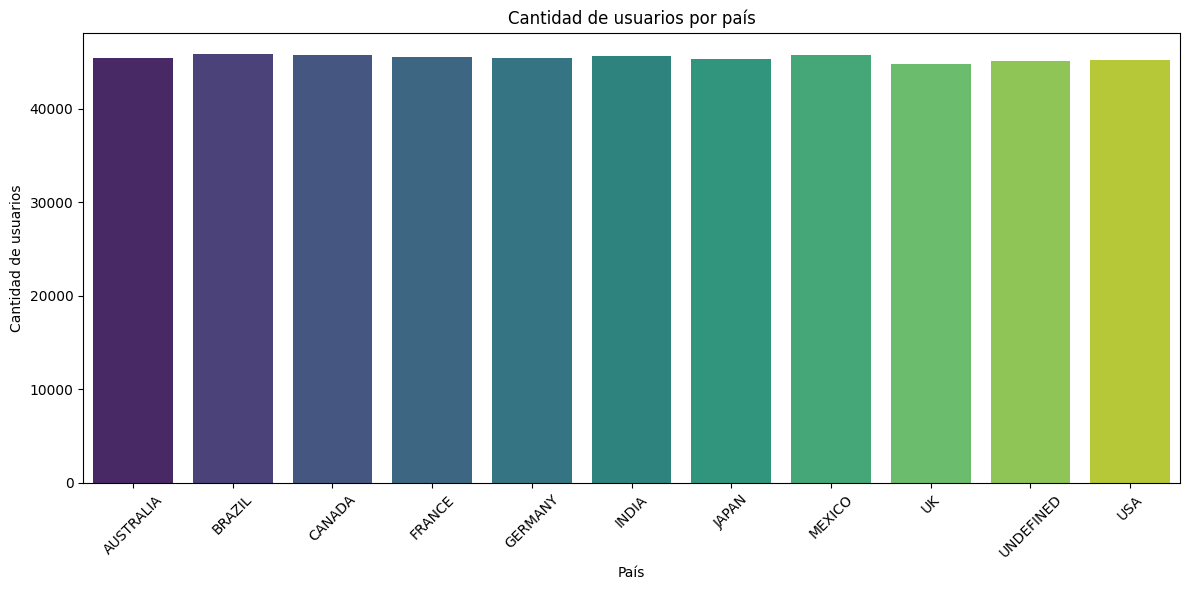

In [138]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=customers['country'].value_counts().reset_index(),
    x="country", y="count",palette="viridis")
plt.xticks(rotation=45)
plt.xlabel('País')
plt.ylabel('Cantidad de usuarios')
plt.title('Cantidad de usuarios por país')
plt.tight_layout()

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\210948131.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customers.groupby(["registration_year_month", "customer_segment"])["customer_id"].nunique().unstack()\


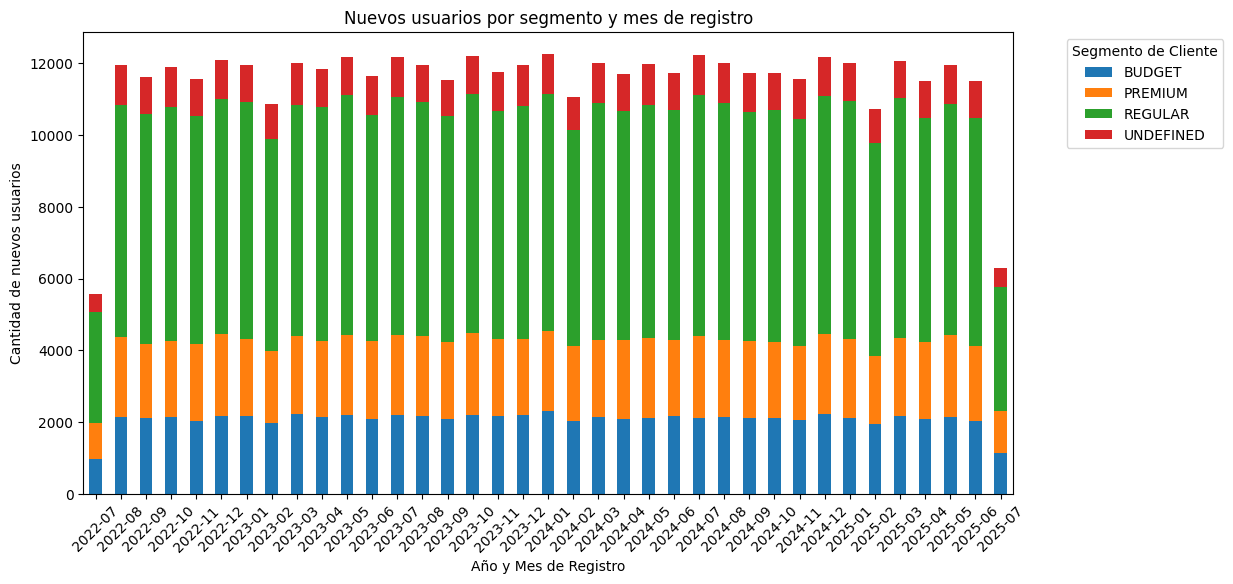

In [139]:
customers.groupby(["registration_year_month", "customer_segment"])["customer_id"].nunique().unstack()\
    .plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel('Año y Mes de Registro')
plt.ylabel('Cantidad de nuevos usuarios')
plt.title('Nuevos usuarios por segmento y mes de registro')
plt.xticks(rotation=45)
plt.legend(title='Segmento de Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\1246693486.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_count_segment_year_month = customers.groupby(["registration_year_month", "customer_segment"])["customer_id"].nunique().unstack()


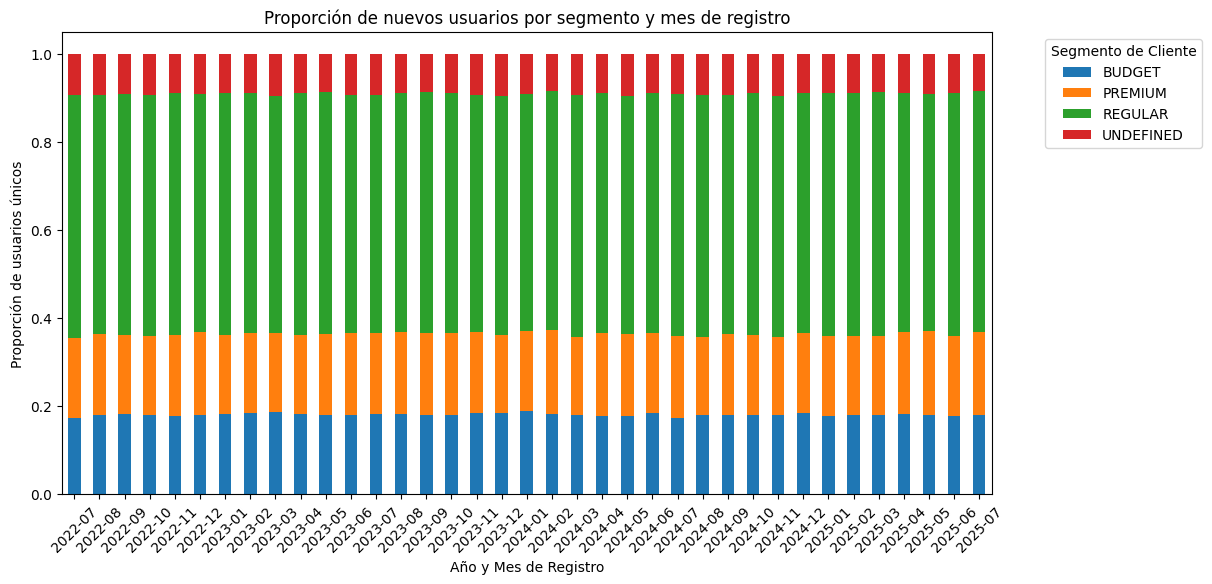

In [140]:
customer_count_segment_year_month = customers.groupby(["registration_year_month", "customer_segment"])["customer_id"].nunique().unstack()
customer_count_segment_year_month.div(customer_count_segment_year_month.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel('Año y Mes de Registro')
plt.ylabel('Proporción de usuarios únicos')
plt.title('Proporción de nuevos usuarios por segmento y mes de registro')
plt.xticks(rotation=45)
plt.legend(title='Segmento de Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

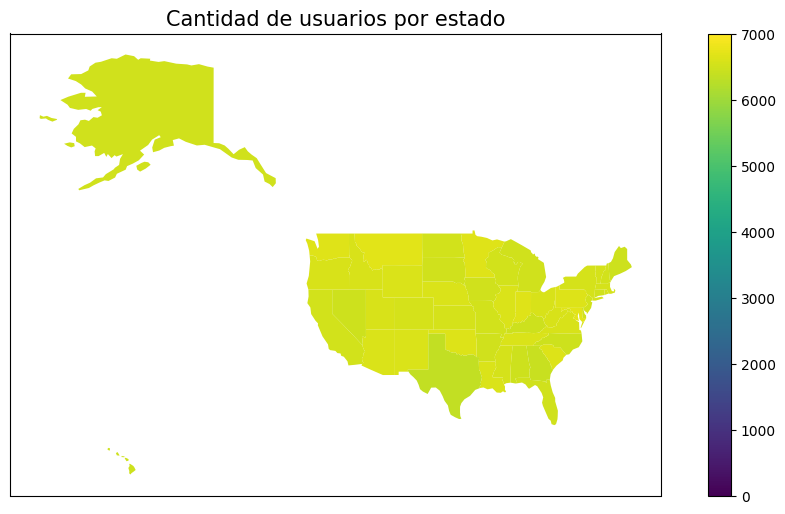

In [141]:
import geopandas as gpd
states = gpd.read_file("states_and_provinces/ne_110m_admin_1_states_provinces.shp")

df = customers['state'].value_counts().reset_index()
states = states.merge(df, how="left", left_on="postal", right_on="state")

fig, ax = plt.subplots(figsize=(12,6))
states.plot(
    column="count",
    legend=True,
    ax=ax,
    vmin=0,
    vmax=7000
)
ax.set_title("Cantidad de usuarios por estado", fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

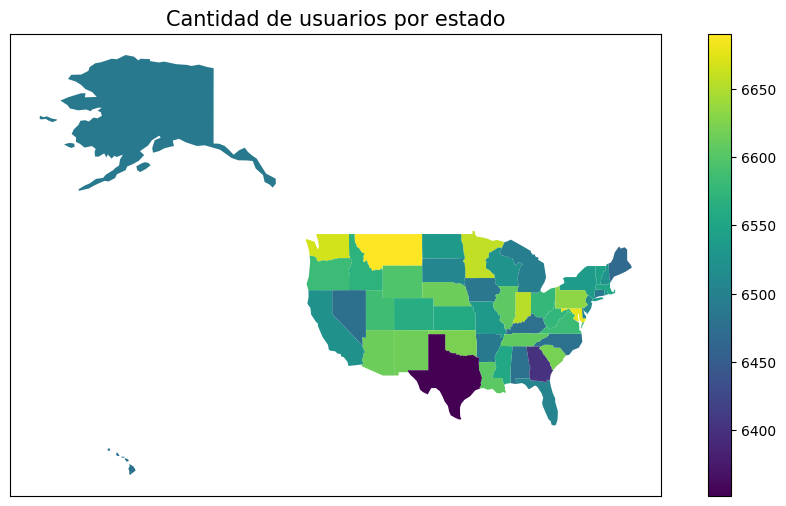

In [142]:
import geopandas as gpd
states = gpd.read_file("states_and_provinces/ne_110m_admin_1_states_provinces.shp")

df = customers['state'].value_counts().reset_index()
states = states.merge(df, how="left", left_on="postal", right_on="state")

fig, ax = plt.subplots(figsize=(12,6))
states.plot(
    column="count",
    legend=True,
    ax=ax,
)
ax.set_title("Cantidad de usuarios por estado", fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [143]:
del customers

### Órdenes

#### Limpieza

In [144]:
orders = pd.read_csv(
    'data/orders.csv',
    usecols=[
        'order_id',
        'customer_id',
        'status',
        'payment_method',
        'billing_address',
        'discount_amount',
        'order_date'
    ],
    dtype={
        'order_id': 'uint32',
        'customer_id': 'uint32',
        'discount_amount': 'float32',
        'status': 'category',
        'payment_method': 'category',
    },
)

In [145]:
orders = normalize_string_column_values(orders, 'status')
orders = normalize_string_column_values(orders, 'payment_method')
orders.fillna({"status":"UNDEFINED", "payment_method":"UNDEFINED"}, inplace=True)
orders['status'] = orders['status'].astype('category')
orders['payment_method'] = orders['payment_method'].astype('category')

orders["billing_address"] = orders["billing_address"].str.upper()
pattern = r'([A-Z]{2})\s(\d{5})'
orders[["state", "zip_code"]] = orders["billing_address"].str.extract(pattern)
orders.state = orders.state.astype('category')
orders.zip_code = orders.zip_code.astype('UInt32')
orders.drop(columns=["billing_address"], inplace=True)

orders["order_date"] = pd.to_datetime(orders["order_date"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce")
orders["date"] = pd.DatetimeIndex(orders["order_date"]).date
orders["year_month"] = pd.DatetimeIndex(orders["order_date"]).strftime('%Y-%m')
orders.drop(columns=["order_date"], inplace=True)

#### Gráficos

Text(0, 0.5, 'Cantidad de órdenes')

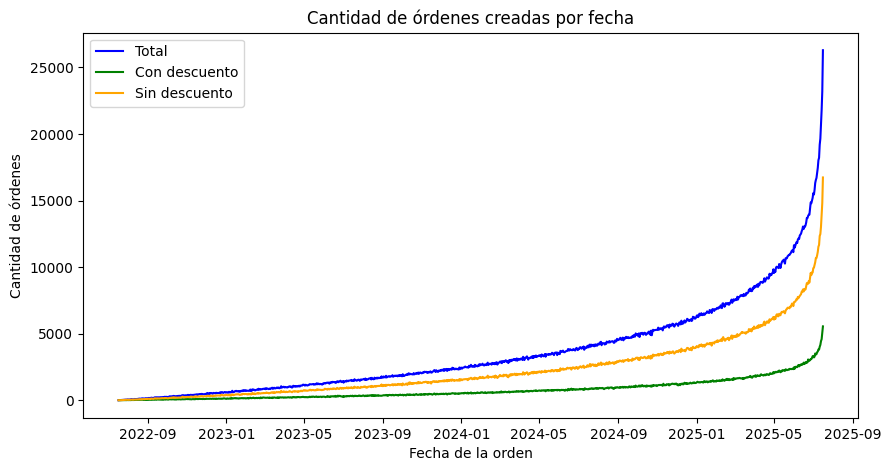

In [146]:
import datetime

plt.figure(figsize=(10, 5))
plt.title("Cantidad de órdenes creadas por fecha")

limit_date = datetime.date(2025, 7, 17) # fecha del último dato en el dataset, no representativo
dates_filtered = orders.loc[orders.date != limit_date][["date", "discount_amount"]]

sns.lineplot(
    data=dates_filtered["date"].value_counts().reset_index(), 
    x="date", y="count", color="blue", label="Total")
sns.lineplot(
    data=dates_filtered.loc[dates_filtered["discount_amount"] > 0]["date"].value_counts().reset_index(), 
    x="date", y="count", color="green", label="Con descuento")
sns.lineplot(
    data=dates_filtered.loc[dates_filtered["discount_amount"] == 0]["date"].value_counts().reset_index(), 
    x="date", y="count", color="orange", label="Sin descuento")
plt.xlabel("Fecha de la orden")
plt.ylabel("Cantidad de órdenes")

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\3276102185.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=orders_per_state, x="state", y="count", palette="viridis")


Text(0, 0.5, 'Cantidad de órdenes')

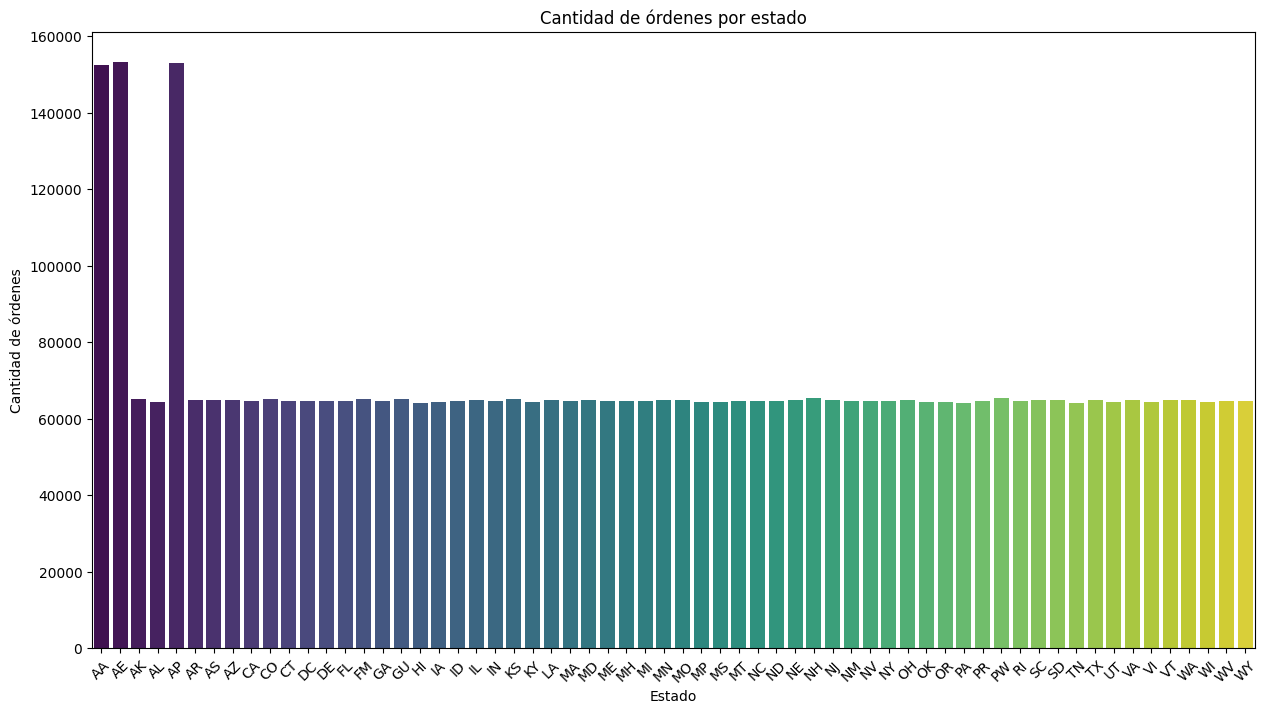

In [147]:
orders_per_state = orders["state"].value_counts().reset_index()
plt.figure(figsize=(15, 8))
sns.barplot(data=orders_per_state, x="state", y="count", palette="viridis")
plt.xticks(rotation=45)
plt.title("Cantidad de órdenes por estado")
plt.xlabel("Estado")
plt.ylabel("Cantidad de órdenes")

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\2209011103.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_per_state_year_month = orders.groupby(["state","year_month"]).size().reset_index().rename(columns={0: "count"})


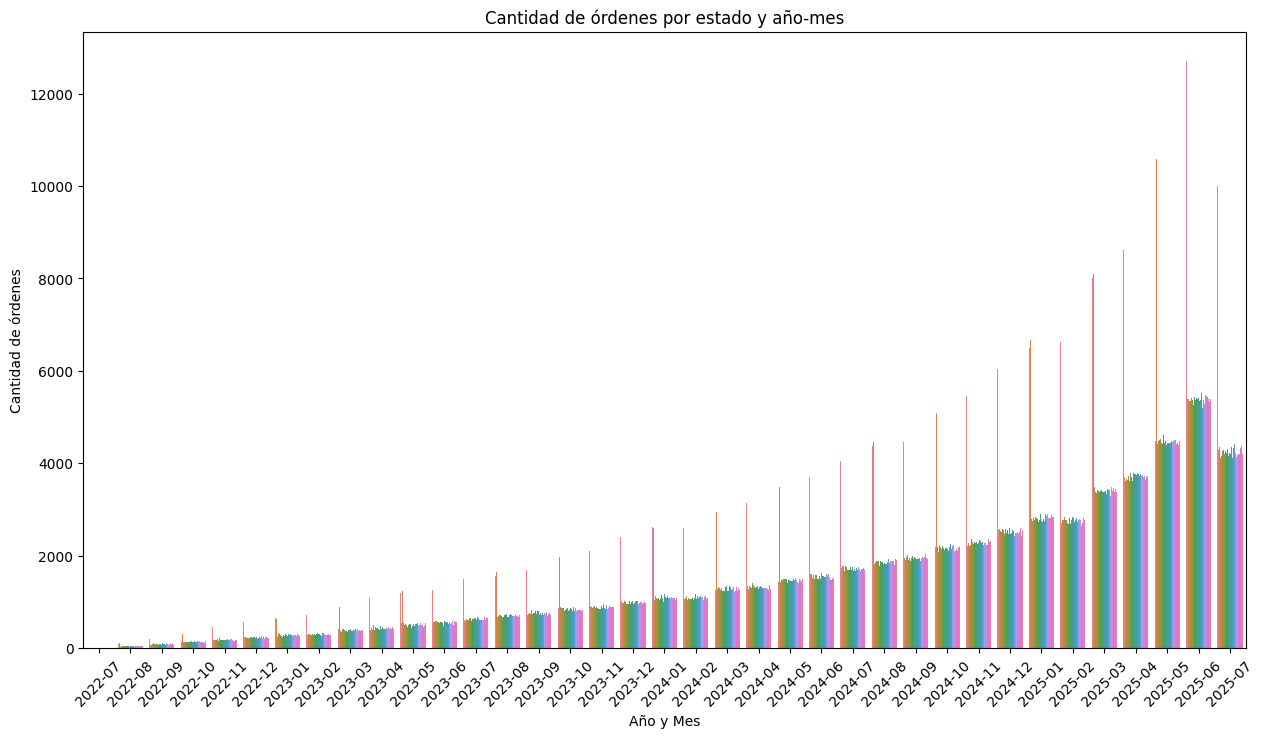

In [148]:
orders_per_state_year_month = orders.groupby(["state","year_month"]).size().reset_index().rename(columns={0: "count"})
plt.figure(figsize=(15, 8))
sns.barplot(data=orders_per_state_year_month, x="year_month", y="count", hue="state")
plt.title("Cantidad de órdenes por estado y año-mes")
plt.xlabel("Año y Mes")
plt.xticks(rotation=45)
plt.ylabel("Cantidad de órdenes")
plt.legend([],[], frameon=False)

In [149]:
del orders

### Inventario

#### Limpieza

In [159]:
inventory = pd.read_csv(
    'data/inventory_logs.csv',
    usecols=[
        'log_id',
        'movement_type',
        'timestamp',
        'reason',
        'quantity_change',
    ],
    dtype={
        'log_id': 'uint32',
        'movement_type': 'category',
        'reason': 'category',
    },
)

In [160]:
normalize_string_column_values(inventory, 'movement_type')
normalize_string_column_values(inventory, 'reason')
inventory.fillna({"movement_type":"UNDEFINED", "reason":"UNDEFINED"}, inplace=True)
inventory['movement_type'] = inventory['movement_type'].astype('category')
inventory['reason'] = inventory['reason'].astype('category')

inventory.dropna(subset=['quantity_change'], inplace=True)
inventory['quantity_change'] = inventory['quantity_change'].astype('int32')

inventory["timestamp"] = pd.to_datetime(inventory["timestamp"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce")
inventory["date"] = pd.DatetimeIndex(inventory["timestamp"]).date
inventory["year_month"] = pd.DatetimeIndex(inventory["timestamp"]).strftime('%Y-%m')
inventory.drop(columns=["timestamp"], inplace=True)

#### Gráficos

Todas las reason tienen logs con entradas y salidas de productos (y valores nulos).<br>
Entonces, la columna "reason" es un poco ambigua.

¿Por qué hay registros de robos (theft) en las que hay valores positivos y negativos?<br>
¿Robaron cosas del inventario, pero también ingresaron cosas robadas al inventario?<br>

Ídem con los artículos dañados (damage)

In [161]:
inventory["change_sign"] = -1
inventory.loc[inventory["quantity_change"].notnull() & (inventory["quantity_change"] > 0), "change_sign"] = 1
inventory.loc[inventory["quantity_change"].notnull() & (inventory["quantity_change"] < 0), "change_sign"] = 0

inventory.groupby("reason")["change_sign"].nunique()

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\1367441317.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  inventory.groupby("reason")["change_sign"].nunique()


reason
ADJUSTMENT    3
DAMAGE        3
PURCHASE      3
RETURN        3
SALE          3
THEFT         3
TRANSFER      3
UNDEFINED     3
Name: change_sign, dtype: int64

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\2339110712.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = inventory.groupby(["movement_type", "date"], as_index=False)["log_id"].count()


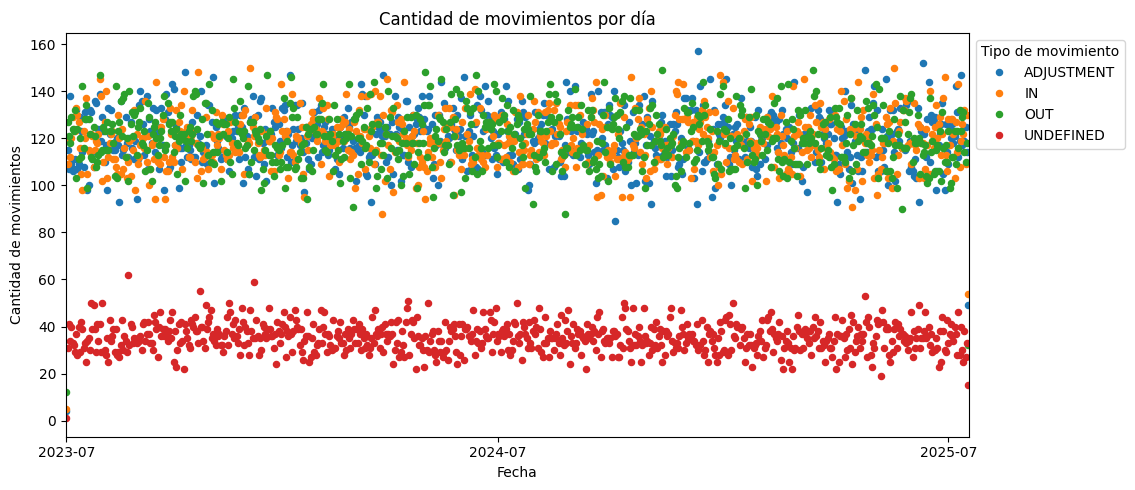

In [162]:
plt.figure(figsize=(10, 5))
data = inventory.groupby(["movement_type", "date"], as_index=False)["log_id"].count()
for move in data["movement_type"].unique():    
    sns.pointplot(
        data.loc[data["movement_type"] == move],
        x="date", y="log_id", label=move, linestyles='', markers='.'
    )
plt.xlabel("Fecha")
plt.ylabel("Cantidad de movimientos")
plt.title("Cantidad de movimientos por día")
plt.xticks(ticks=["2023-07-17", "2024-07-01", "2025-07-01"], labels=["2023-07", "2024-07", "2025-07"])
plt.tight_layout()
plt.legend(title="Tipo de movimiento", bbox_to_anchor=(1, 1), loc='upper left')

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\707655129.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = inventory.groupby(["year_month", "reason"])["log_id"].count().unstack()


<Figure size 1000x500 with 0 Axes>

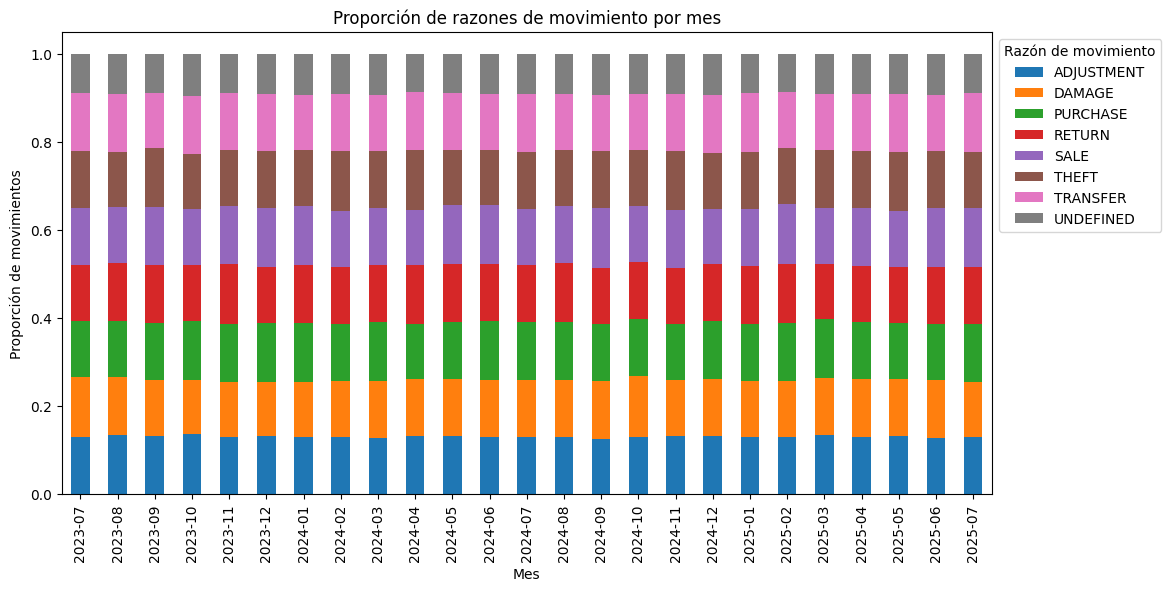

In [163]:
plt.figure(figsize=(10, 5))
data = inventory.groupby(["year_month", "reason"])["log_id"].count().unstack()
data.div(data.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Mes")
plt.ylabel("Proporción de movimientos")
plt.title("Proporción de razones de movimiento por mes")
plt.legend(title="Razón de movimiento", bbox_to_anchor=(1, 1), loc='upper left')

C:\Users\Patricio\AppData\Local\Temp\ipykernel_11696\1461134562.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = inventory.groupby(["year_month", "movement_type"])["quantity_change"].sum().unstack()


<Figure size 1000x500 with 0 Axes>

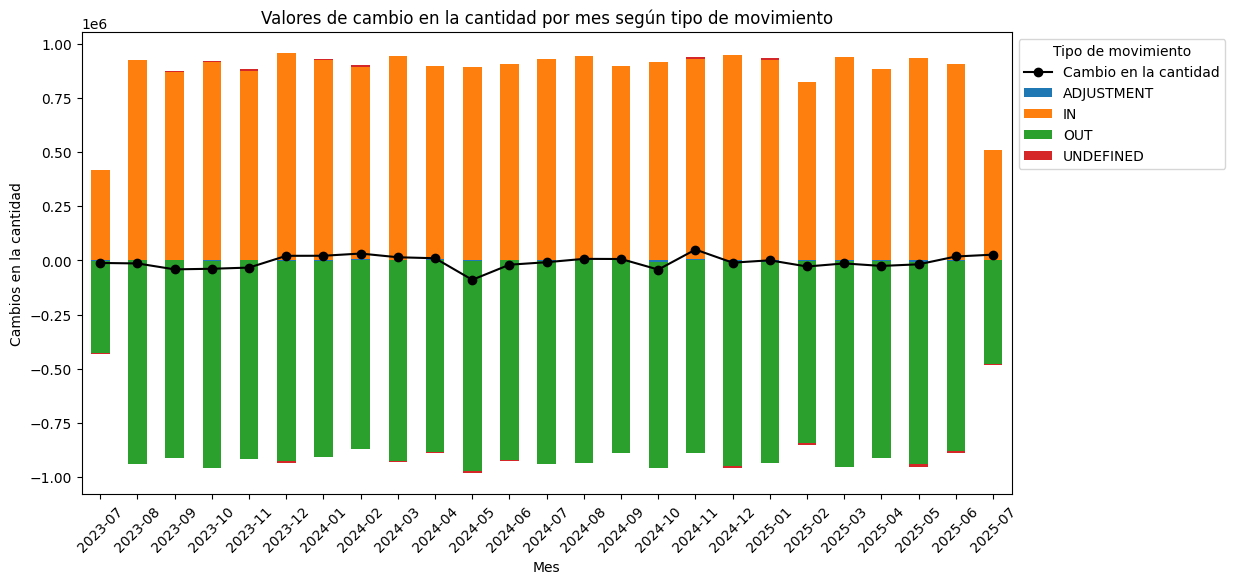

In [164]:
# tipo de movimiento por mes
plt.figure(figsize=(10, 5))
data = inventory.groupby(["year_month", "movement_type"])["quantity_change"].sum().unstack()
data.plot(kind='bar', stacked=True, figsize=(12,6))
data["total"] = data.sum(axis=1) # total de cambios por mes, sumando todos los tipos de movimiento
data["total"].plot(marker='o', color='black', label='Cambio en la cantidad', legend=True)
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Cambios en la cantidad")
plt.title("Valores de cambio en la cantidad por mes según tipo de movimiento")
plt.legend(title="Tipo de movimiento", bbox_to_anchor=(1, 1), loc='upper left')

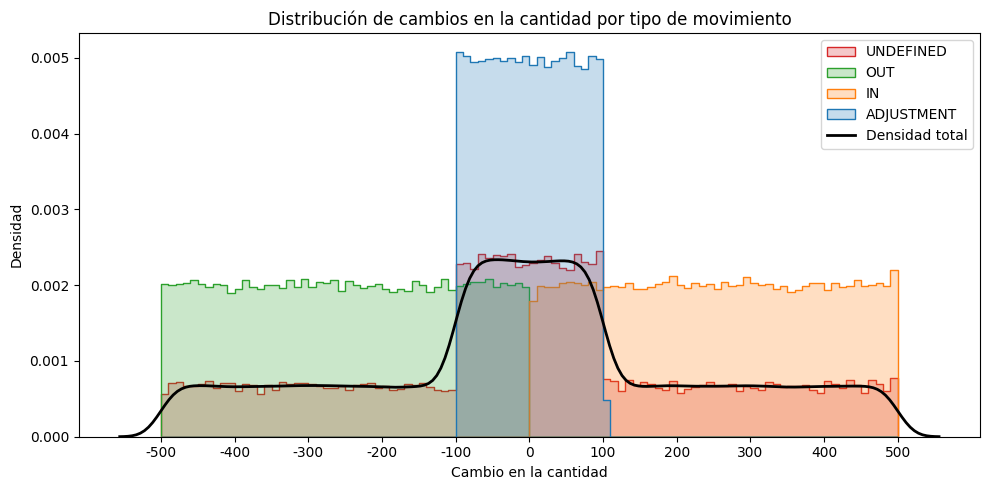

In [171]:
plt.figure(figsize=[10, 5])
# histograma de cambios en la cantidad por tipo de movimiento
sns.histplot(
    data=inventory.rename(columns={"movement_type": "Tipo de movimiento", "quantity_change": "Cambio en la cantidad"}),
    x="Cambio en la cantidad",
    hue="Tipo de movimiento",
    bins=100,
    stat="density",
    common_norm=False,             # no normalizar entre las categorías
    element="step"                 # sin lineas rellenas
)
# funcion de densidad de probabilidad total
sns.kdeplot(
    data=inventory,
    x="quantity_change",
    color="black",
    linewidth=2,
)
plt.ylabel("Densidad")
plt.title("Distribución de cambios en la cantidad por tipo de movimiento")
xticks = list(range(-500, 501, 100))
plt.xticks(ticks=xticks, labels=xticks)
legend_labels = plt.gca().get_legend().get_texts()[::-1]
legend_labels.append(plt.Text(0, 0, "Densidad total", color="black"))
plt.legend(labels=[text.get_text() for text in legend_labels])
plt.tight_layout()

In [166]:
# del inventory